# Cubic Splines

In [24]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# For model and evaluation
from scipy.interpolate import LSQUnivariateSpline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [2]:
# Define the data points and intervals
np.random.seed(8)
X = np.linspace(0, 6, 500)  # 500 points spanning [0, 6]
Y = np.cos(X)**3 + 2*np.sin(X)**2 + np.random.normal(0, 0.5, 500)  # Generate noisy data

# Split the data into training, validation, and testing sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, 
                                                    random_state=8)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, 
                                                random_state=8)

# For fitting the function once hyperparameters are selected
X_train_val = np.concatenate((X_train, X_val))
Y_train_val = np.concatenate((Y_train, Y_val))

# Sort to ensure strictly increasing x values
sorted_indices = np.argsort(X_train)
X_train = X_train[sorted_indices]
Y_train = Y_train[sorted_indices]

sorted_indices = np.argsort(X_val)
X_val = X_val[sorted_indices]
Y_val = Y_val[sorted_indices]

sorted_indices = np.argsort(X_train_val)
X_train_val = X_train_val[sorted_indices]
Y_train_val = Y_train_val[sorted_indices]

Y_true = np.cos(X)**3 + 2*np.sin(X)**2

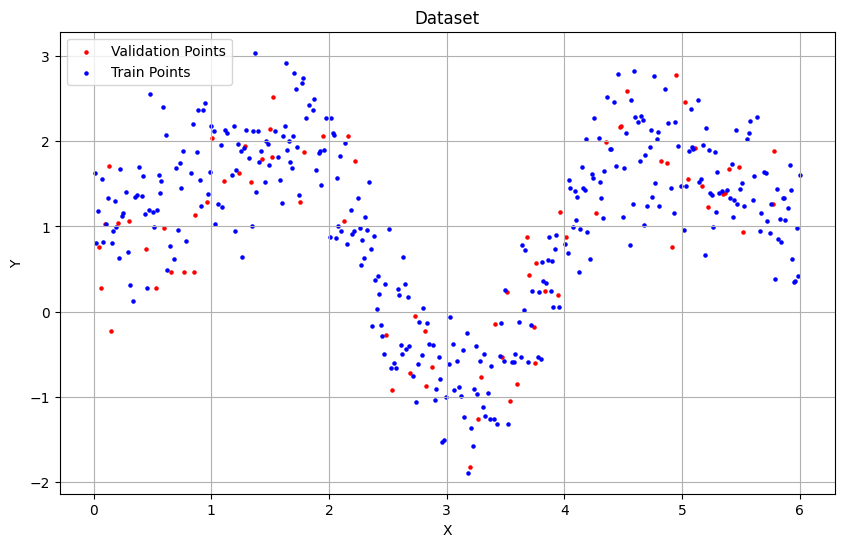

In [3]:
# Plot training and validation sets
plt.figure(figsize=(10, 6))
plt.scatter(X_val, Y_val, label='Validation Points', color='red', s=5)
plt.scatter(X_train, Y_train, label='Train Points', color='blue', s=5)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Dataset')
plt.grid(True)
plt.show()

In [4]:
def generate_random_knots_list(X):
    
    # Ensure X is sorted
    X = np.sort(X)

    # Initialize the knots list with the minimum and maximum of X
    knots = [X[0], X[-1]]

    # Set number of knots 
    num_knots = random.randint(2, 8)

    # Add intermediate knots
    for _ in range(num_knots):
        valid_knots = [x for x in X if x > knots[-2] and x < knots[-1]]
        if not valid_knots:
            break
        new_knot = random.choice(valid_knots)
        knots.insert(-1, new_knot)

    return sorted(knots[1:-1])




In [20]:
# Generate search space 

case_num = 100
cases = []

for _ in range(case_num):
    
    cases.append(generate_random_knots_list(X_train))

In [21]:
mse_values = []
r2_values = []

for knots in cases: 
    # build model
    model = LSQUnivariateSpline(X_train, Y_train, t=knots)

    # Predict validation
    Y_pred = model(X_val)
    
    # Calculate metrics on the testing set
    mse_values.append(mean_squared_error(Y_pred, Y_val))
    r2_values.append(r2_score(Y_pred, Y_val))


mse = min(mse_values)
best_knots = cases[np.argmin(mse_values)]
r2 = r2_values[np.argmin(mse_values)]

# Display metrics of result
print(f"Best knots of the randomly generated cases is: {best_knots}")
print(f"Mean Squared Error (MSE) of best knots: {mse:.4f}")
print(f"R-squared (R2) of best knots: {r2:.4f}")

Best knots of the randomly generated cases is: [1.2024048096192386, 2.3927855711422845, 2.8016032064128256, 4.68937875751503, 5.458917835671342, 5.927855711422846]
Mean Squared Error (MSE) of best knots: 0.2897
R-squared (R2) of best knots: 0.6594


In [22]:
# Fit the cubic spline model
final_model = LSQUnivariateSpline(X_train_val, Y_train_val, t=knots)
Y_test_pred = final_model(X_test)

mse = mean_squared_error(Y_test_pred, Y_test)
r2 = r2_score(Y_test_pred, Y_test)
# Display metrics of result
print(f"Mean Squared Error (MSE) of chosen model: {mse:.4f}")
print(f"R-squared (R2) of best chosen model: {r2:.4f}")

Mean Squared Error (MSE) of chosen model: 0.3753
R-squared (R2) of best chosen model: 0.4981


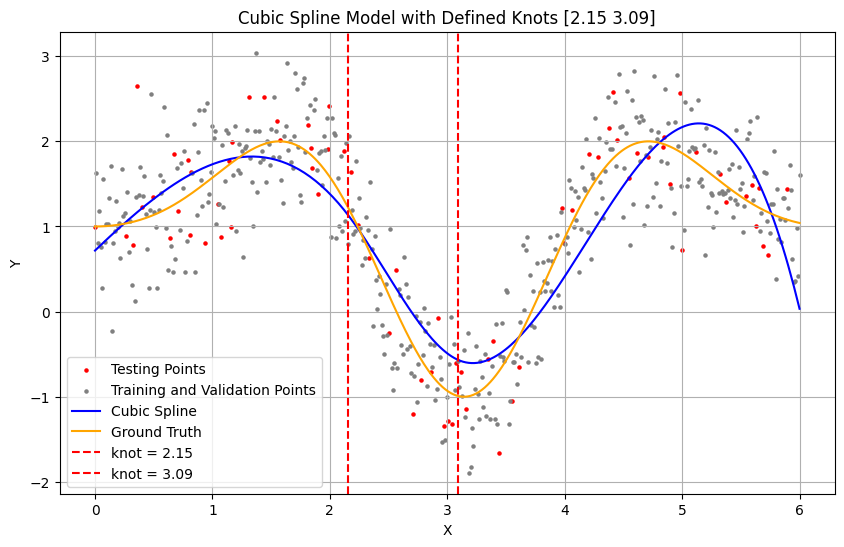

In [23]:
X_new = np.linspace(0, 6, 250)
Y_pred_new = final_model(X_new)

# Plot the original data and the cubic spline interpolation
plt.figure(figsize=(10, 6))
plt.scatter(X_test, Y_test, label='Testing Points', color='red', s=5)
plt.scatter(X_train_val, Y_train_val, label='Training and Validation Points', color='gray', s=5)
plt.plot(X_new, Y_pred_new, label='Cubic Spline', color='blue')
plt.plot(X, Y_true, label='Ground Truth', color='orange')
for k in knots:
    plt.axvline(x=k, color='red', linestyle='--', label=f'knot = {round(k, 2)}')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title(f'Cubic Spline Model with Defined Knots {np.round(knots, 2)}')
plt.grid(True)
plt.show()



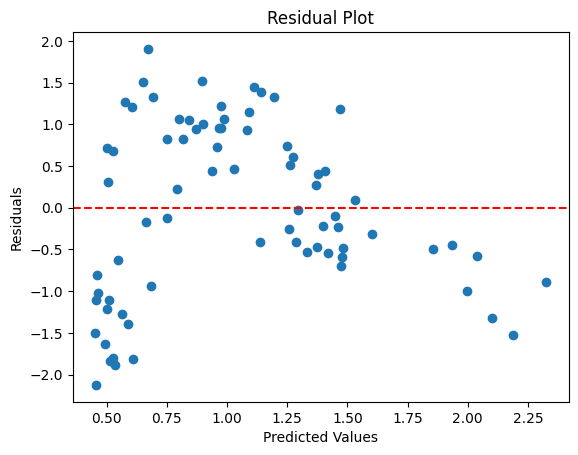

In [19]:
residuals = Y_test - Y_test_pred

# Plotting the residuals
plt.scatter(Y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Show the plot
plt.show()

## Write Up 

Write a blurb describing your work above. 

**Note that every time this code is run, the reults are different.**

In this assignment, we fit a cubic spline to a syntethetic dataset whose ground truth is 
$$Y = \cos^3(X) + \sin^2(X) + \epsilon.$$

The primary objective was to model this data using a cubic spline with the `LSQUnivariateSpline` from the `ScipPy` package (see [LSQUnivariateSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LSQUnivariateSpline.html#scipy-interpolate-lsqunivariatespline)). The process began by dividing the dataset into three subsets: training, validation, and testing. Here, we need a validation set as the knots are a hyperparameter of the model that has a profound impact on its shape. 

We randomly generat a set of knots ranging from 2 to 8 that sataify the Schoenberg-Whitney conditions (see [The Schoenberg-Whitney theorem and total positivity](https://www.uio.no/studier/emner/matnat/math/MAT4170/v22/undervisningsmateriale/schoenberg-whitney.pdf)). 

Once the optimal set of knots was determined, we constructed the final cubic spline model using both the training and validation sets. This model was then evaluated against the unseen testing set to assess its predictive performance. The resulting R2 score of 0.4981 provided a quantitative measure of the model's explanatory power, indicating a moderate fit to the data. The associated MSE was 0.3753.

Additionally, we conducted a residual analysis by plotting the residuals of the model. The presence of a  pattern in these residuals suggested that the model, while reasonably effective, might not fully capture all the underlying dynamics of the data. This insight points to the possibility of model inadequacy, suggesting that further refinement or a different modeling approach might be needed to better fit the complex nature of the dataset.

Overall, this model does not seem sufficient for modeling this data. 